## Constants

In [1]:
pathToTrainImages = "D:/Perfect Shape Images/Train/"
pathToTestImages = "D:/Perfect Shape Images/Test/"

In [2]:
BATCH_SIZE = 4
SIMILARITY_COEFFICIENT = 0.002

## Imports

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import os

c:\users\vijsh\appdata\local\programs\python\python37\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


## Create Dataloader

### Create Dataloader Class

In [4]:
class ShapeDataset(Dataset):
    """Shape dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample. -> Not used
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                str(idx)+ '.jpg')
        image = cv2.imread(img_name)

        if self.transform:
            image = self.transform(image)

        #perfect square should yield strongest activation which will be 1
        return image, 1

### Set Transforms

In [5]:
transform = transforms.ToTensor()

### Create datasets and dataloaders

In [6]:
trainset = ShapeDataset(pathToTrainImages, transform)
testset = ShapeDataset(pathToTrainImages, transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## View Sample Images + Test Loaders

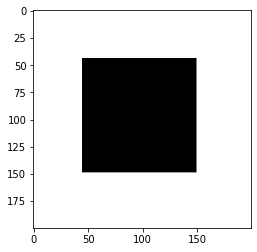

In [7]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, label = dataiter.next()

npimg = np.transpose(images[0], (1, 2, 0))

plt.imshow(npimg)

## Create CNN

### Define Network

In [8]:
class SquareNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.conv2 = nn.Conv2d(20, 40, 3)
        self.conv3 = nn.Conv2d(40, 60, 3)
        self.fc1 = nn.Linear(13500, 5000)
        self.fc2 = nn.Linear(5000, 1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(3)    
        self.sigmoid = nn.Sigmoid()
        
        self.identity = torch.Tensor(3, 200, 200)
        self.identity[0] = self.identity[1] = self.identity[2] = torch.eye(200)
        self.identity = self.identity.to("cuda")
                
    def forward(self, x):
        #Next: Add identity mapping that has gradients, freeze it
        #Unfreeze the identity layer during testing
        x = torch.matmul(x, self.identity)
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool1(F.relu(self.conv2(x)))
        x = self.maxpool2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
net = SquareNet()

In [10]:
net.identity.requires_grad

False

In [11]:
net.to("cuda")

SquareNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=13500, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1, bias=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

## Define Loss Function and Optimizer

In [ ]:
# Define a custom loss function that incorporates the similarity score
class CustomLoss(nn.Module):
    def __init__(self, weight_similarity=1.0):
        super(CustomLoss, self).__init__()
        self.weight_similarity = weight_similarity

    def forward(self, features1, features2, similarity_score):
        # Calculate the cosine similarity loss
        cosine_loss = 1.0 - similarity_score
        # Multiply it by the weight for tuning
        cosine_loss = self.weight_similarity * cosine_loss

        return cosine_loss

# Compute similarity between two images
def image_similarity(image_path1, image_path2, model):
    image1 = preprocess_image(image_path1)
    image2 = preprocess_image(image_path2)

    # Extract features from the images using the provided model
    with torch.no_grad():
        features1 = model(image1)
        features2 = model(image2)

    # Compute the cosine similarity between the feature vectors
    similarity_score = cosine_similarity(features1, features2)

    return similarity_score

# Example usage with custom loss and optimization
image_path_square1 = "square1.jpg"
image_path_square2 = "square2.jpg"
image_path_triangle = "triangle.jpg"
image_path_rectangle = "rectangle.jpg"

model = load_pretrained_model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
custom_loss = CustomLoss(weight_similarity=1.0)

for _ in range(1000):  # Training loop
    # Calculate similarity scores for pairs of images
    similarity_score_square_square = image_similarity(image_path_square1, image_path_square2, model)
    similarity_score_square_triangle = image_similarity(image_path_square1, image_path_triangle, model)
    similarity_score_square_rectangle = image_similarity(image_path_square1, image_path_rectangle, model)

    # Compute the loss
    loss = custom_loss(None, None, similarity_score_square_square) + custom_loss(None, None, similarity_score_square_triangle)

    # Backpropagate and update the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Loss: {loss.item()}")

# After training, you can use the trained model to compute similarity scores for any pair of images.

In this modified code, we've created a custom loss function CustomLoss that incorporates the similarity score as a term in the loss. You can adjust the weight_similarity parameter to control how much importance the similarity score has in the overall loss. Inside the training loop, we compute the similarity scores for pairs of images and use them to calculate the loss. Then, we backpropagate the gradients and update the model using an optimizer.

After training, you can use the trained model to compute similarity scores for any pair of images as needed.


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

In [13]:
lossList = []
net.train()

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        labels = labels[...,None]

        loss = criterion(outputs, labels.float())# + SIMILARITY_COEFFICIENT * torch.linalg.cross()
        loss.backward()
        optimizer.step()
        
#         change = net.identity.grad
#         change = change.cpu()
#         change = np.transpose(change, (1, 2, 0))
        
        lossList.append(loss.item())

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.6f}')
            running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.159055
[1,    10] loss: 0.000881
[1,    15] loss: 0.000043
[1,    20] loss: 0.000041
[1,    25] loss: 0.000034
[1,    30] loss: 0.000025
[1,    35] loss: 0.000011
[1,    40] loss: 0.000001
[1,    45] loss: 0.000006
[1,    50] loss: 0.000004
[2,     5] loss: 0.000003
[2,    10] loss: 0.000006
[2,    15] loss: 0.000012
[2,    20] loss: 0.000002
[2,    25] loss: 0.000004
[2,    30] loss: 0.000005
[2,    35] loss: 0.000004
[2,    40] loss: 0.000002
[2,    45] loss: 0.000002
[2,    50] loss: 0.000002
[3,     5] loss: 0.000001
[3,    10] loss: 0.000001
[3,    15] loss: 0.000001
[3,    20] loss: 0.000001
[3,    25] loss: 0.000001
[3,    30] loss: 0.000001
[3,    35] loss: 0.000000
[3,    40] loss: 0.000000
[3,    45] loss: 0.000000
[3,    50] loss: 0.000000
[4,     5] loss: 0.000000
[4,    10] loss: 0.000000
[4,    15] loss: 0.000000
[4,    20] loss: 0.000001
[4,    25] loss: 0.000001
[4,    30] loss: 0.000000
[4,    35] loss: 0.000000
[4,    40] loss: 0.000001
[4,    45] l

KeyboardInterrupt: 

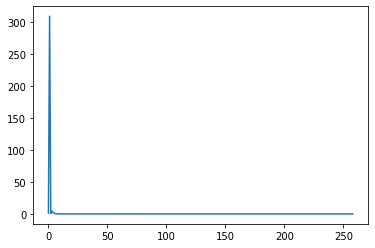

In [14]:
plt.plot(lossList)

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to("cuda"), labels.to("cuda")

outputs = net(images)

In [16]:
outputs

tensor([[0.9674],
        [0.9791],
        [0.9818],
        [0.9793]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
labels

tensor([1, 1, 1, 1], device='cuda:0')

# Freeze rest of network and unfreeze identity layer

In [18]:
for param in net.parameters():
    param.requires_grad = False

net.identity.requires_grad = True

net.to("cuda")

SquareNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=13500, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1, bias=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

In [20]:
rec = torch.Tensor(cv2.imread(pathToTestImages + "rectangle.jpg"))
rec = rec[...,None]
rec = np.transpose(rec, (3, 2, 0, 1))
rec = rec.to("cuda")

In [21]:
labels = torch.Tensor([1])
labels = labels.to("cuda")
labels = labels[...,None]
labels

tensor([[1.]], device='cuda:0')

In [22]:
optimizer.zero_grad()

In [23]:
outputs = net(rec)
outputs

tensor([[146.4023]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [24]:
loss = criterion(outputs, labels.float())

In [25]:
loss.backward()

# Edit original image

In [59]:
change = net.identity - 0.002 * net.identity.grad
change = change.cpu()
# change = np.transpose(change, (1, 2, 0))

In [60]:
recCpu = rec.cpu()[0]
recCpu = np.transpose(recCpu, (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


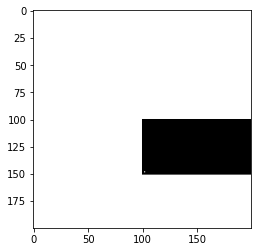

In [61]:
plt.imshow(recCpu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


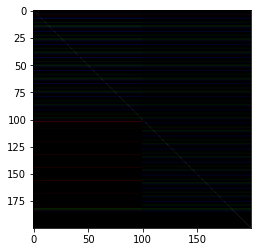

In [66]:
plt.imshow(change.transpose(0, 2).detach().numpy() * 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


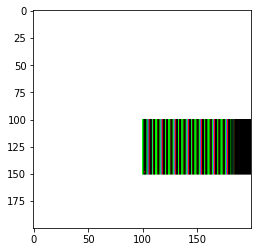

In [142]:
plt.imshow(recCpu - change*0.003)

## Testing Code

In [6]:
rec = torch.Tensor(cv2.imread(pathToTestImages + "rectangle.jpg"))
rec = rec[...,None]
rec = np.transpose(rec, (3, 2, 0, 1))
rec = rec.to("cuda")

In [7]:
test = torch.Tensor(3, 200, 200)
test[0] = test[1] = test[2] = torch.eye(200)
test = test.to("cuda")

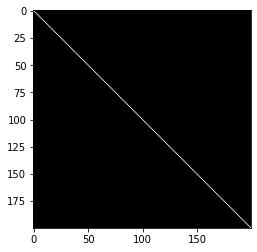

In [25]:
plt.imshow(test.cpu().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


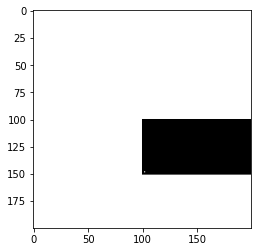

In [22]:
plt.imshow(rec.cpu()[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


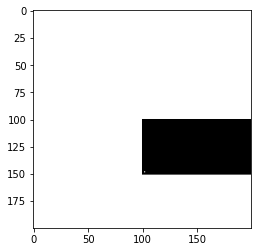

In [8]:
plt.imshow(np.transpose(torch.matmul(test, rec[0]).cpu(), (1, 2, 0)))

TypeError: Invalid shape (3, 200, 200) for image data

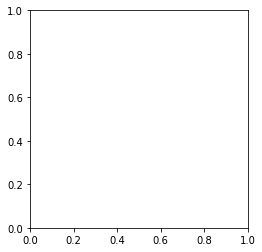

In [17]:
plt.imshow(np.transpose(torch.matmul(test, rec[0]).cpu(), (1, 2, 0)))

In [9]:
testingCross = np.transpose(torch.matmul(test, rec[0]).cpu(), (1, 2, 0))

In [34]:
check = rec[0].permute(1, 2, 0)

In [35]:
similarity = torch.linalg.cross(check, check)

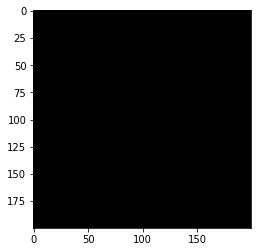

In [37]:
plt.imshow(similarity.cpu())

In [38]:
similarity.sum()

tensor(0., device='cuda:0')

In [2]:
torch.__version__

'1.12.1+cu113'

In [86]:
output = net(rec)

In [87]:
output

tensor([[186.8507]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [88]:
m = nn.Conv2D(3, 3, )
m.to("cuda")

Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))

In [89]:
test = m(images)

In [7]:
newImg = test[0].cpu().detach().numpy()
bgr = np.transpose(newImg, (1, 2, 0))


plt.imshow(bgr)


ValueError: axes don't match array

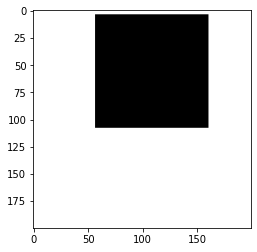

In [91]:
newImg = images[0].cpu().detach().numpy()
bgr = np.transpose(newImg, (1, 2, 0))


plt.imshow(bgr)

In [ ]:
torch.T